In [3]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [4]:
df=pd.read_csv('gdp data.csv',index_col='Years', parse_dates=['Years'])
df

,GDP (current USD in billions),Inflation Rate CPI (compared to previous year),Annual Change in inflation rate,Unemployment Rate (% of labor force) (modeled IMO estimate),Foreign Direct Investment Inflow (in billions of USD),General Government final consumption expenditure (% of GDP)
Years,,,,,,
1960-01-01,37.03,1.78,NaN,NaN,NaN,6.6
1961-01-01,39.23,1.70,0.08,NaN,NaN,6.9
1962-01-01,42.16,3.63,-1.93,NaN,NaN,7.8
1963-01-01,48.42,2.95,0.68,NaN,NaN,8.7
1964-01-01,56.48,13.36,-10.41,NaN,NaN,8.0
...,...,...,...,...,...,...
2019-01-01,2840.00,3.73,0.21,6.51,50.61,11.0
2020-01-01,2670.00,6.62,-2.89,7.90,64.36,11.6
2021-01-01,3150.00,5.13,1.49,6.40,44.73,11.2


In [5]:
df.isnull().sum()

GDP (current USD in billions)                                   0
Inflation Rate CPI (compared to previous year)                  1
Annual Change in inflation rate                                 2
Unemployment Rate (% of labor force) (modeled IMO estimate)    31
Foreign Direct Investment Inflow (in billions of USD)          10
General Government final consumption expenditure (% of GDP)     1
dtype: int64

In [6]:
df5=df.dropna()

In [7]:
df2=df.fillna({'Inflation Rate CPI (compared to previous year)': 5.69,
              'General Government final consumption expenditure (% of GDP)': 9.3})

In [8]:
df2

,GDP (current USD in billions),Inflation Rate CPI (compared to previous year),Annual Change in inflation rate,Unemployment Rate (% of labor force) (modeled IMO estimate),Foreign Direct Investment Inflow (in billions of USD),General Government final consumption expenditure (% of GDP)
Years,,,,,,
1960-01-01,37.03,1.78,NaN,NaN,NaN,6.6
1961-01-01,39.23,1.70,0.08,NaN,NaN,6.9
1962-01-01,42.16,3.63,-1.93,NaN,NaN,7.8
1963-01-01,48.42,2.95,0.68,NaN,NaN,8.7
1964-01-01,56.48,13.36,-10.41,NaN,NaN,8.0
...,...,...,...,...,...,...
2019-01-01,2840.00,3.73,0.21,6.51,50.61,11.0
2020-01-01,2670.00,6.62,-2.89,7.90,64.36,11.6
2021-01-01,3150.00,5.13,1.49,6.40,44.73,11.2


In [9]:
historical_avg = df.loc[df['Unemployment Rate (% of labor force) (modeled IMO estimate)'].notna(), 'Unemployment Rate (% of labor force) (modeled IMO estimate)'].mean()
df3=df2.fillna({'Unemployment Rate (% of labor force) (modeled IMO estimate)': historical_avg})
df3

,GDP (current USD in billions),Inflation Rate CPI (compared to previous year),Annual Change in inflation rate,Unemployment Rate (% of labor force) (modeled IMO estimate),Foreign Direct Investment Inflow (in billions of USD),General Government final consumption expenditure (% of GDP)
Years,,,,,,
1960-01-01,37.03,1.78,NaN,7.554242,NaN,6.6
1961-01-01,39.23,1.70,0.08,7.554242,NaN,6.9
1962-01-01,42.16,3.63,-1.93,7.554242,NaN,7.8
1963-01-01,48.42,2.95,0.68,7.554242,NaN,8.7
1964-01-01,56.48,13.36,-10.41,7.554242,NaN,8.0
...,...,...,...,...,...,...
2019-01-01,2840.00,3.73,0.21,6.510000,50.61,11.0
2020-01-01,2670.00,6.62,-2.89,7.900000,64.36,11.6
2021-01-01,3150.00,5.13,1.49,6.400000,44.73,11.2


In [134]:
hist_avg = df.loc[df['Foreign Direct Investment Inflow (in billions of USD)'].notna(), 'Foreign Direct Investment Inflow (in billions of USD)'].mean()
df4=df3.fillna({'Foreign Direct Investment Inflow (in billions of USD)': hist_avg})
df4.head(20)

,GDP (current USD in billions),Inflation Rate CPI (compared to previous year),Annual Change in inflation rate,Unemployment Rate (% of labor force) (modeled IMO estimate),Foreign Direct Investment Inflow (in billions of USD),General Government final consumption expenditure (% of GDP)
Years,,,,,,
1960-01-01,37.03,1.78,NaN,7.554242,13.759815,6.6
1961-01-01,39.23,1.70,0.08,7.554242,13.759815,6.9
1962-01-01,42.16,3.63,-1.93,7.554242,13.759815,7.8
1963-01-01,48.42,2.95,0.68,7.554242,13.759815,8.7
1964-01-01,56.48,13.36,-10.41,7.554242,13.759815,8.0
1965-01-01,59.55,9.47,3.89,7.554242,13.759815,8.8
1966-01-01,45.87,10.80,-1.33,7.554242,13.759815,8.5
1967-01-01,50.13,13.06,-2.26,7.554242,13.759815,8.1
1968-01-01,53.09,3.24,9.82,7.554242,13.759815,8.4


In [11]:
X1 = df4.drop(columns = 'GDP (current USD in billions)')
X = X1.drop(columns='Annual Change in inflation rate')
X

,Inflation Rate CPI (compared to previous year),Unemployment Rate (% of labor force) (modeled IMO estimate),Foreign Direct Investment Inflow (in billions of USD),General Government final consumption expenditure (% of GDP)
Years,,,,
1960-01-01,1.78,7.554242,13.759815,6.6
1961-01-01,1.70,7.554242,13.759815,6.9
1962-01-01,3.63,7.554242,13.759815,7.8
1963-01-01,2.95,7.554242,13.759815,8.7
1964-01-01,13.36,7.554242,13.759815,8.0
...,...,...,...,...
2019-01-01,3.73,6.510000,50.610000,11.0
2020-01-01,6.62,7.900000,64.360000,11.6
2021-01-01,5.13,6.400000,44.730000,11.2


In [12]:
y = df4['GDP (current USD in billions)']

In [40]:
corr_matrix = df.corr().round(2)

In [39]:
corr_matrix

,GDP (current USD in billions),Inflation Rate CPI (compared to previous year),Annual Change in inflation rate,Unemployment Rate (% of labor force) (modeled IMO estimate),Foreign Direct Investment Inflow (in billions of USD),General Government final consumption expenditure (% of GDP)
GDP (current USD in billions),1.00,-0.13,0.01,-0.29,0.89,0.32
Inflation Rate CPI (compared to previous year),-0.13,1.00,-0.56,-0.04,-0.15,0.01
Annual Change in inflation rate,0.01,-0.56,1.00,0.00,-0.00,0.13
Unemployment Rate (% of labor force) (modeled IMO estimate),-0.29,-0.04,0.00,1.00,-0.11,0.07
Foreign Direct Investment Inflow (in billions of USD),0.89,-0.15,-0.00,-0.11,1.00,0.09
General Government final consumption expenditure (% of GDP),0.32,0.01,0.13,0.07,0.09,1.00


In [42]:
corr_matrix['GDP (current USD in billions)']

GDP (current USD in billions)                                  1.00
Inflation Rate CPI (compared to previous year)                -0.12
Annual Change in inflation rate                                0.01
Unemployment Rate (% of labor force) (modeled IMO estimate)   -0.39
Foreign Direct Investment Inflow (in billions of USD)          0.94
General Government final consumption expenditure (% of GDP)    0.38
Name: GDP (current USD in billions), dtype: float64

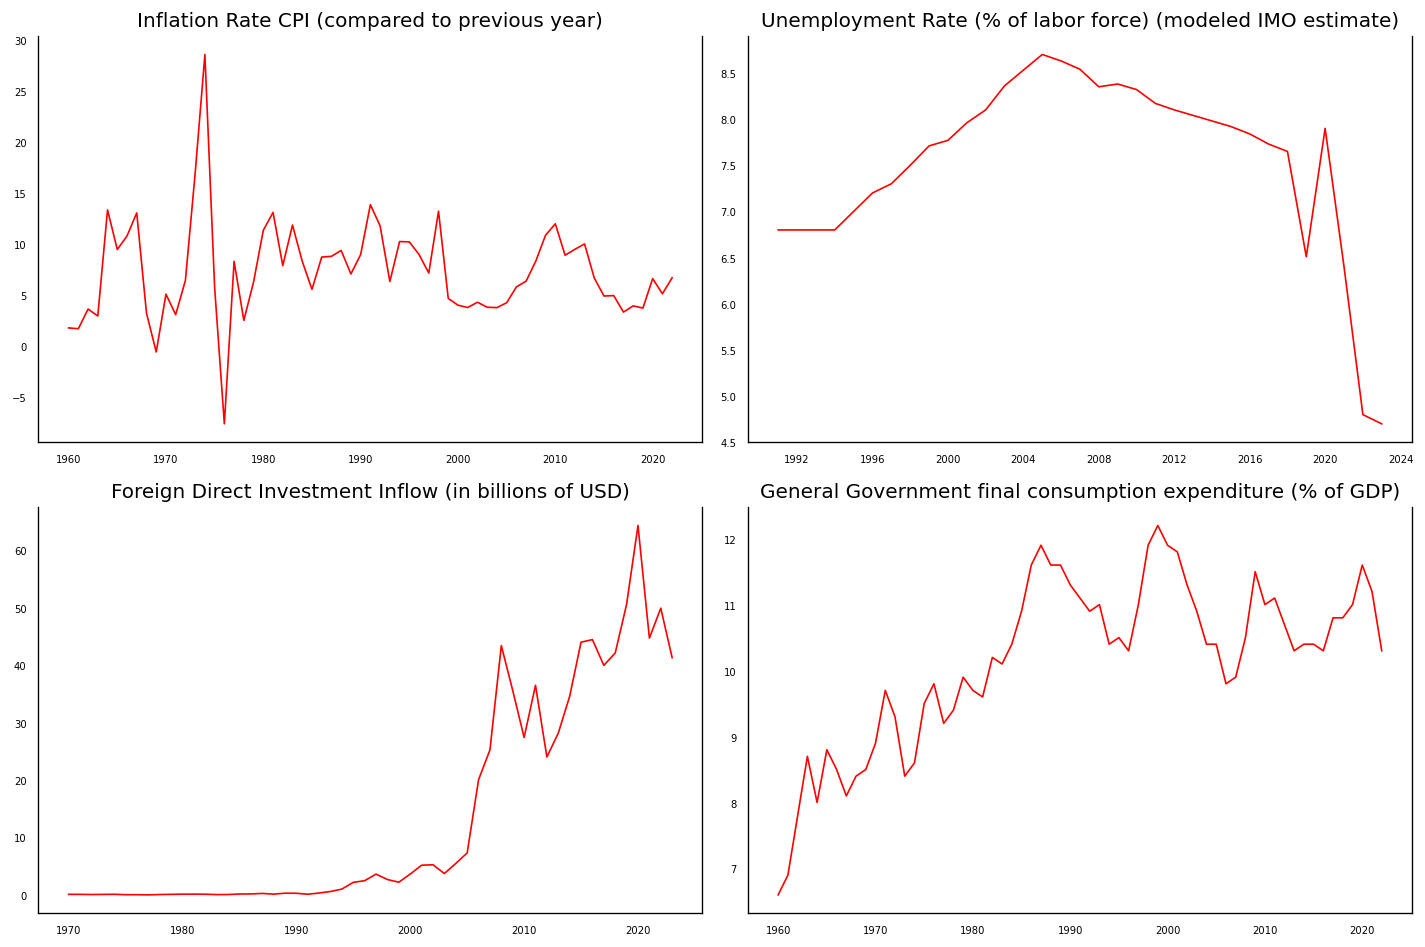

In [51]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(12,8))
for i, ax in enumerate(axes.flatten()):
    data = df[X.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(X.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();
plt.savefig('groupedplot.png')

In [53]:
#augmented dickey-fuller test
def ad_test(dataset):
    dftest = adfuller(dataset,autolag = 'AIC')
    print("1. ADF : ", dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used for ADF Regression and Critical Values Calculation : ", dftest[3])
    print("5. Critical Values : ")
    for key, val in dftest[4].items():
        print("\t",key,":",val)

In [54]:
ad_test(df4['Foreign Direct Investment Inflow (in billions of USD)'])

1. ADF :  -0.7996995060502328
2. P-Value :  0.819210319524085
3. Num Of Lags :  0
4. Num Of Observations Used for ADF Regression and Critical Values Calculation :  63
5. Critical Values : 
	 1% : -3.5386953618719676
	 5% : -2.9086446751210775
	 10% : -2.591896782564878


In [15]:
ad_fuller_result_1 = adfuller(df4['GDP (current USD in billions)'])

print('gdp')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(df4['Foreign Direct Investment Inflow (in billions of USD)'])

print('fdi')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')
     

gdp
ADF Statistic: 2.824556736760176
p-value: 1.0

---------------------

fdi
ADF Statistic: -0.7996995060502328
p-value: 0.819210319524085


In [63]:
GDP=df4['GDP (current USD in billions)']
GDP_log = np.log(GDP)
GDP_log_diff = GDP_log.diff().dropna()
result = adfuller(GDP_log_diff)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
#GDP_log_diff.plot(figsize=(12,5))
#plt.title('Stationary GDP of India (USD in billions)')
#plt.savefig('GDP_Stat.png',transparent=True)

FDI=df4['Foreign Direct Investment Inflow (in billions of USD)']
FDI_log = np.log(FDI)
FDI_log_diff = FDI_log.diff().dropna()
result = adfuller(FDI_log_diff)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'critical values:')
for key, val in result[4].items():
        print("\t",key,":",val)

ADF Statistic: -7.577563762049556
p-value: 2.735882076141862e-11
ADF Statistic: -4.306623259289989
p-value: 0.00043262615304660683
critical values:
	 1% : -3.5745892596209488
	 5% : -2.9239543084490744
	 10% : -2.6000391840277777


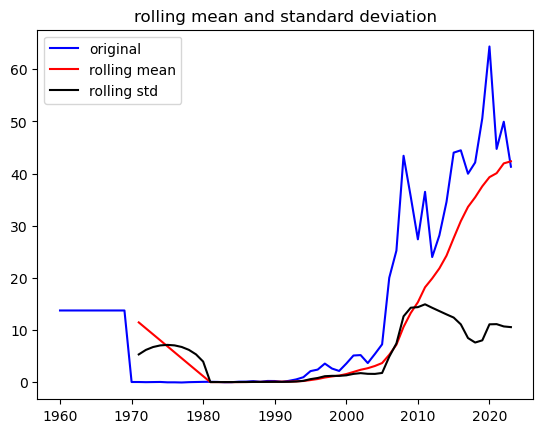

In [132]:
rollmean = df4['Foreign Direct Investment Inflow (in billions of USD)'].rolling(window=12).mean()
rollstd = df4['Foreign Direct Investment Inflow (in billions of USD)'].rolling(window=12).std()
orig = plt.plot(df4['Foreign Direct Investment Inflow (in billions of USD)'], color ='blue', label='original')
mean = plt.plot(rollmean, color='red', label='rolling mean')
std =plt.plot(rollstd, color='black', label="rolling std")
plt.legend(loc='best')
plt.title("rolling mean and standard deviation")
plt.savefig('fdi_rolling.png',transparent=True)

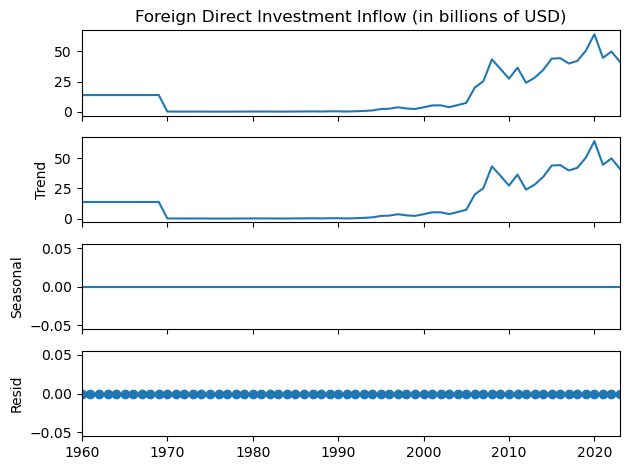

In [64]:
decomposition = sm.tsa.seasonal_decompose(df4['Foreign Direct Investment Inflow (in billions of USD)'], model='additive')
fig=decomposition.plot()
plt.savefig('fdi_trend')

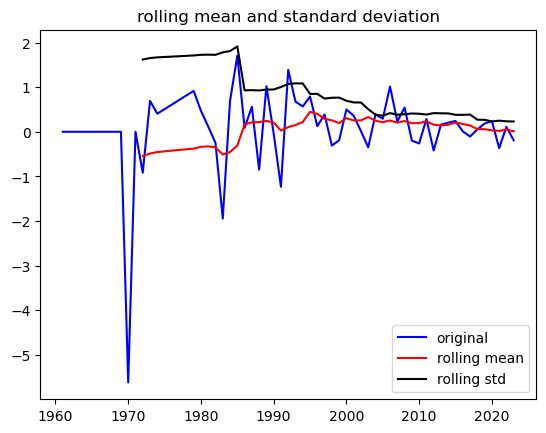

In [66]:
rollmean = FDI_log_diff.rolling(window=12).mean()
rollstd = FDI_log_diff.rolling(window=12).std()
orig = plt.plot(FDI_log_diff, color ='blue', label='original')
mean = plt.plot(rollmean, color='red', label='rolling mean')
std =plt.plot(rollstd, color='black', label="rolling std")
plt.legend(loc='best')
plt.title("rolling mean and standard deviation")
plt.savefig('fdi_rolling_stat.png',transparent=True)

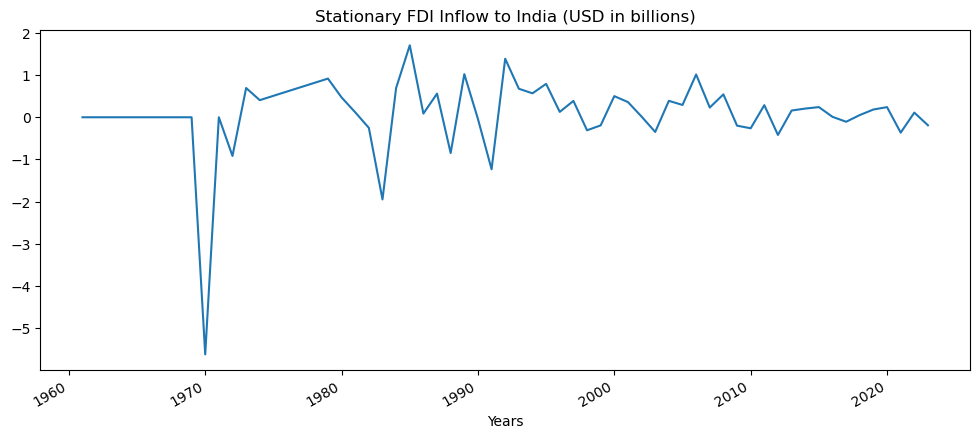

In [22]:
FDI_log_diff.plot(figsize=(12,5))
plt.title('Stationary FDI Inflow to India (USD in billions)')
plt.savefig('FDI_Stat.png',transparent=True)

In [156]:
print('gdp causes fdi?\n')
print('------------------')
granger_1 = grangercausalitytests(df4[['Foreign Direct Investment Inflow (in billions of USD)', 'GDP (current USD in billions)']], 4)

print('fdi causes gdp?\n')
print('------------------')
granger_2 = grangercausalitytests(df4[['GDP (current USD in billions)', 'Foreign Direct Investment Inflow (in billions of USD)']], 4)


gdp causes fdi?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.4638  , p=0.0032  , df_denom=60, df_num=1
ssr based chi2 test:   chi2=9.9370  , p=0.0016  , df=1
likelihood ratio test: chi2=9.2270  , p=0.0024  , df=1
parameter F test:         F=9.4638  , p=0.0032  , df_denom=60, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.2944 , p=0.0002  , df_denom=57, df_num=2
ssr based chi2 test:   chi2=22.3948 , p=0.0000  , df=2
likelihood ratio test: chi2=19.1190 , p=0.0001  , df=2
parameter F test:         F=10.2944 , p=0.0002  , df_denom=57, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.9104  , p=0.0002  , df_denom=54, df_num=3
ssr based chi2 test:   chi2=26.8075 , p=0.0000  , df=3
likelihood ratio test: chi2=22.2206 , p=0.0001  , df=3
parameter F test:         F=7.9104  , p=0.0002  , df_denom=54, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test: 

In [69]:
fin = df4[['GDP (current USD in billions)', 'Foreign Direct Investment Inflow (in billions of USD)']]
print(fin.shape)
fin

(64, 2)


,GDP (current USD in billions),Foreign Direct Investment Inflow (in billions of USD)
Years,,
1960-01-01,37.03,13.759815
1961-01-01,39.23,13.759815
1962-01-01,42.16,13.759815
1963-01-01,48.42,13.759815
1964-01-01,56.48,13.759815
...,...,...
2019-01-01,2840.00,50.610000
2020-01-01,2670.00,64.360000
2021-01-01,3150.00,44.730000


In [70]:
train_df=fin[:-8]
test_df=fin[-8:]

In [71]:
train_log = np.log(train_df)
train_log_diff = train_log.diff().dropna()
model = VAR(train_log_diff)

In [72]:
sorted_order=model.select_order(maxlags=16)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -5.801      -5.713    0.003023      -5.771
1       -5.632      -5.365    0.003586      -5.540
2       -5.500      -5.056    0.004103      -5.347
3       -5.465      -4.843    0.004278      -5.251
4       -5.455      -4.655    0.004378      -5.179
5       -5.317      -4.339    0.005131      -4.979
6       -5.507      -4.352    0.004372      -5.108
7       -5.340      -4.007    0.005400      -4.879
8       -5.355      -3.845    0.005647      -4.834
9       -5.258      -3.569    0.006763      -4.675
10      -5.207      -3.341    0.007950      -4.563
11      -5.202      -3.158    0.009284      -4.496
12      -5.233      -3.012     0.01103      -4.466
13      -5.327      -2.928     0.01333      -4.499
14      -6.606      -4.029    0.005593      -5.717
15      -7.603      -4.848    0.003929      -6.652
16     -11.88*     -8.946*  0.0

In [110]:
var_model = VAR(train_df)#, order=(16,0),enforce_stationarity= True)
model_fit = var_model.fit()
print(model_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 07, Apr, 2024
Time:                     18:50:38
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    11.4004
Nobs:                     55.0000    HQIC:                   11.2661
Log likelihood:          -457.572    FPE:                    71798.9
AIC:                      11.1814    Det(Omega_mle):         64563.5
--------------------------------------------------------------------
Results for equation GDP (current USD in billions)
                                                              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------------------------------------
const                                                            4.385731        10.269825            0.427     

In [120]:

from pandas.tseries.frequencies import to_offset

# Assuming your data is a pandas DataFrame with a DatetimeIndex
n_forecast = 8

predict = model_fit.get_prediction(start=len(train_df), end=len(train_df) + n_forecast - 1)
predictions = predict.predicted_mean

AttributeError: 'VARResults' object has no attribute 'get_prediction'

In [96]:
predictions.columns=['gdp_predicted','fdi_predicted']
predictions

,gdp_predicted,fdi_predicted
2016-01-01,1574.539176,30.886808
2017-01-01,1561.350551,16.109816
2018-01-01,1306.773130,20.370008
2019-01-01,1385.777847,29.034607
2020-01-01,1185.152597,14.653834
2021-01-01,1253.166610,19.769568
2022-01-01,1228.849781,35.562374
2023-01-01,1318.759761,33.800369


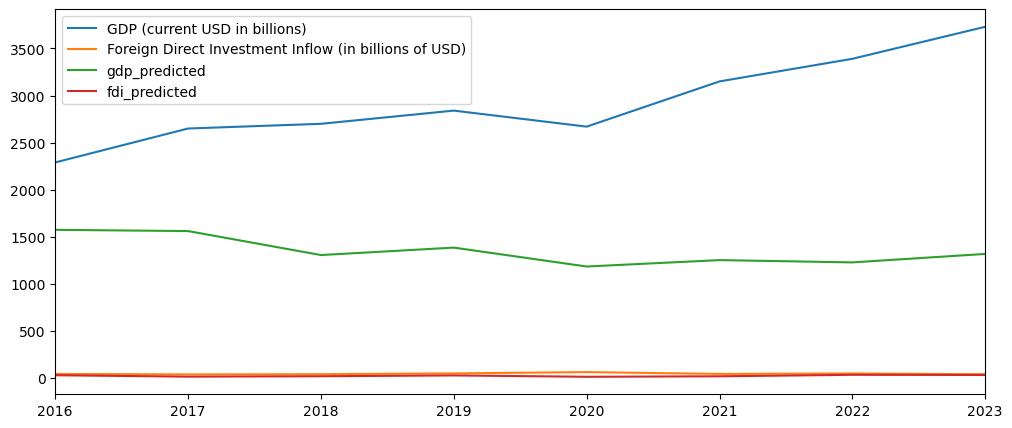

In [133]:
test_vs_pred=pd.concat([test_df,predictions],axis=1)
test_vs_pred.plot(figsize=(12,5))
plt.savefig("fdi_Var.png")

In [98]:
from sklearn.metrics import mean_squared_error
import math 
from statistics import mean

rmse_gdp=math.sqrt(mean_squared_error(predictions['gdp_predicted'],test_df['GDP (current USD in billions)']))
print('Mean value of GDP is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['GDP (current USD in billions)']),rmse_gdp))

rmse_fdi=math.sqrt(mean_squared_error(predictions['fdi_predicted'],test_df['Foreign Direct Investment Inflow (in billions of USD)']))
print('Mean value of FDI is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['Foreign Direct Investment Inflow (in billions of USD)']),rmse_fdi))

Mean value of GDP is : 2927.5. Root Mean Squared Error is :1659.8299414334608
Mean value of FDI is : 47.1875. Root Mean Squared Error is :25.122043229106684


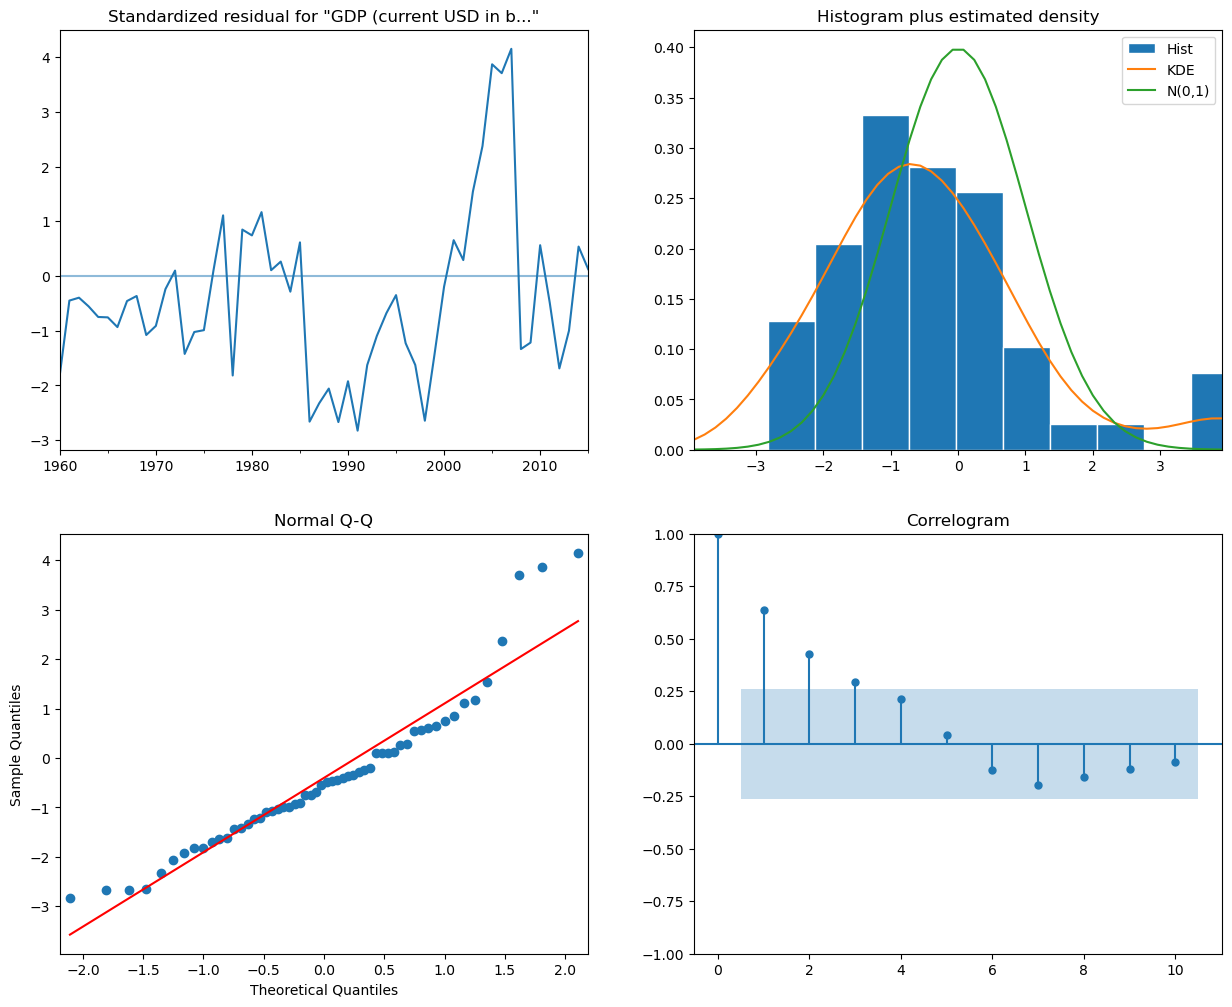

In [103]:
model_fit.plot_diagnostics(figsize=(15,12))
plt.savefig('var_diagnostics.png', transparent=True)

In [131]:
from statsmodels.tsa.stattools import acf, pacf

var_model = VAR(train_df)
model_fit = var_model.fit(16)

results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 07, Apr, 2024
Time:                     19:09:03
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    11.4800
Nobs:                     54.0000    HQIC:                   11.2538
Log likelihood:          -443.261    FPE:                    67021.7
AIC:                      11.1117    Det(Omega_mle):         56143.4
--------------------------------------------------------------------
Results for equation GDP (current USD in billions)
                                                              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------------------------------------
const                                                            5.282507        10.697889            0.494     

In [125]:
from sklearn.metrics import mean_absolute_percentage_error
train = fin.iloc[:-8]
test = fin.iloc[-8:]
model = VAR(train)
results = model.fit(maxlags=2)
lag_order = results.k_ar
fcst = results.forecast(train.values[-lag_order:], 8)
model_accuracy = 1-mean_absolute_percentage_error(test, fcst)
print(model_accuracy)

0.879885351231082
